In [1]:
import numpy as np

from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

In [2]:
#load dataframe from csv
demographics_data = pd.read_csv("data/newdata/2018_demographic_data_edited.csv", delimiter=',')
print(demographics_data.shape)
demographics_data = demographics_data.drop(columns=["Geo_ZCTA5", "Geo_ZCTA3", "Geo_LOGRECNO", "Geo_GEOCOMP", "Geo_SUMLEV"])

(33120, 2151)


In [3]:
null_counts = demographics_data.isnull().sum()
print(null_counts[null_counts > 0])

SE_A01004_001      564
SE_A01004_002      843
SE_A01004_003      897
SE_A10003_001      726
SE_A10003B_001    2496
                  ... 
SE_A13007_009       35
SE_A13007_010       35
SE_A13007_011       35
SE_A10064_001       35
SE_A10064_002       35
Length: 870, dtype: int64


In [4]:
# drop any column with missing values greater than 5%
demographics_data.drop(columns=["SE_A18007_006","SE_A18007_007","SE_A18007_005","SE_A18007_004",
                     "SE_A18007_003","SE_A18007_002","SE_A18008_011",
                     "SE_A18008_010","SE_A18008_009","SE_A18010_002",
                     "SE_A18010_003","SE_A18010_004","SE_A18010_005",
                     "SE_A18010_006","SE_A18010_007","SE_A18008_001","SE_A18008_002",
                     "SE_A18008_003","SE_A18008_008","SE_A18008_007","SE_A18008_006","SE_A18008_005",
                     "SE_A18008_004"], axis=1, inplace=True)

In [47]:
reduced_demos = demographics_data[["SE_A00002_002", "SE_A14028_001", "SE_A14011_001", "SE_A14008_001", "SE_B10040_002", "SE_B10040_003"]]

In [48]:
null_counts = reduced_demos.isnull().sum()
print(null_counts[null_counts > 0])
reduced_demos = reduced_demos.dropna()
print(reduced_demos.shape)
reduced_demos = MinMaxScaler().fit_transform(reduced_demos)

SE_A14028_001     948
SE_A14011_001    1662
dtype: int64
(31458, 2)


What does MinMaxScaler Scaler do to our data?

In [49]:
print(reduced_demos[0:5])

   SE_A14028_001  SE_A14011_001
0         0.5238    20888.83581
1         0.5034    27986.62033
2         0.5666    31688.46383
3         0.4818    18625.70601
4         0.4689    30554.08275


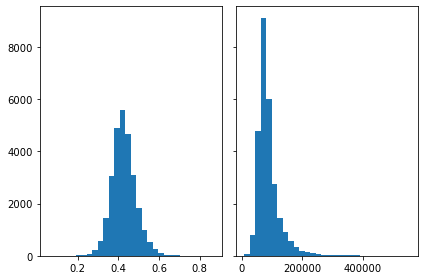

In [95]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

n_bins = 30

# We can set the number of bins with the `bins` kwarg
axs[0].hist(reduced_demos["SE_A14028_001"], bins=n_bins)
axs[1].hist(reduced_demos["SE_A14011_001"], bins=n_bins)
plt.show()

How does our best DBSCAN approach look?

Ok, maybe all along we've been picking bad datapoints to look at, lets just Gini index, Average household income, and rent as a percentage of income.

SE_A14028_001     948
SE_A14011_001    1662
SE_A18003_001    5596
dtype: int64
(27474, 4)
 clusters:  135  and noise points  3815 , noise as :  0.13885855718133508


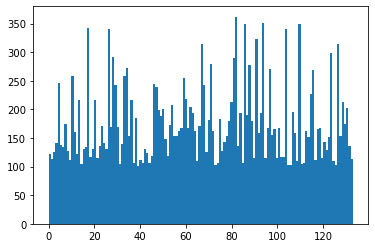

In [97]:

# just gini index and average household income and vacant housing units
reduced_demos = demographics_data[["zip", "SE_A14028_001", "SE_A14011_001", "SE_A18003_001"]]

null_counts = reduced_demos.isnull().sum()
print(null_counts[null_counts > 0])
reduced_demos = reduced_demos.dropna()
print(reduced_demos.shape)
#reduced_demos = StandardScaler().fit_transform(reduced_demos)

reduced_demos_no_zip = reduced_demos.drop("zip", axis=1)

clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=3, cluster_selection_method='leaf')
clusterer.fit(reduced_demos_no_zip)

labels = clusterer.labels_
unique_labels = set(labels)
print( " clusters: ", len(unique_labels), " and noise points ", (labels == -1).sum(), ", noise as : ", (labels == -1).sum()/len(labels))

label_sum = []

for k in unique_labels:
    label_sum.append((labels == k).sum())
    
non_noise = labels[labels != -1]

plt.hist(non_noise, bins=len(unique_labels)-1)
plt.show()

In [116]:
clusters = reduced_demos[['zip']]
clusters["cluster"] = labels
clusters = clusters.rename(columns={"zip":"Region"})
clusters.head()

C:\Users\winbase\Anaconda3\envs\mids\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Region,cluster
0,601,-1
1,602,3
2,603,3
3,606,-1
4,610,3


So using just those 3 statistics we can get some pretty reasonable clusters. Now let's join those up with the sales data.

In [93]:
sales_data = pd.read_csv("data/newdata/med_sale_price_yoy.csv", delimiter="	")
sales_data.index = sales_data.index.astype(int)
sales_data = sales_data.dropna(how = 'all', axis = 0)
sales_data = sales_data.fillna(0)
print(sales_data.head())

   Region February 2016 March 2016 April 2016 May 2016 June 2016 July 2016  \
0     501             0          0          0        0         0         0   
1    1005         15.4%       5.7%     -29.7%   -24.0%     33.7%      8.6%   
2    1010             0          0          0        0         0         0   
3    1031        705.0%     612.0%     -24.6%   -24.6%    -83.2%    -13.7%   
4    1037             0          0     -23.9%        0    102.7%    150.4%   

  August 2016 September 2016 October 2016  ... December 2019 January 2020  \
0           0              0            0  ...             0            0   
1        5.7%          -9.1%        -4.1%  ...          7.3%        -4.3%   
2           0              0            0  ...             0            0   
3       -3.3%          -2.0%        27.6%  ...         43.9%       -13.8%   
4      150.4%              0            0  ...             0            0   

  February 2020 March 2020 April 2020 May 2020 June 2020 July 2020  

In [136]:
Jan2020_sales = sales_data[['Region','January 2020']]
Jan2020_sales = Jan2020_sales.merge(clusters, on="Region")
Jan2020_sales["January 2020"] = Jan2020_sales["January 2020"].str.replace(r'%', r'')
Jan2020_sales = Jan2020_sales.fillna(0)
Jan2020_sales.head()

,Region,January 2020,cluster
0,1005,-4.3,28
1,1010,0,29
2,1031,-13.8,-1
3,1057,0,29
4,1068,33.3,33


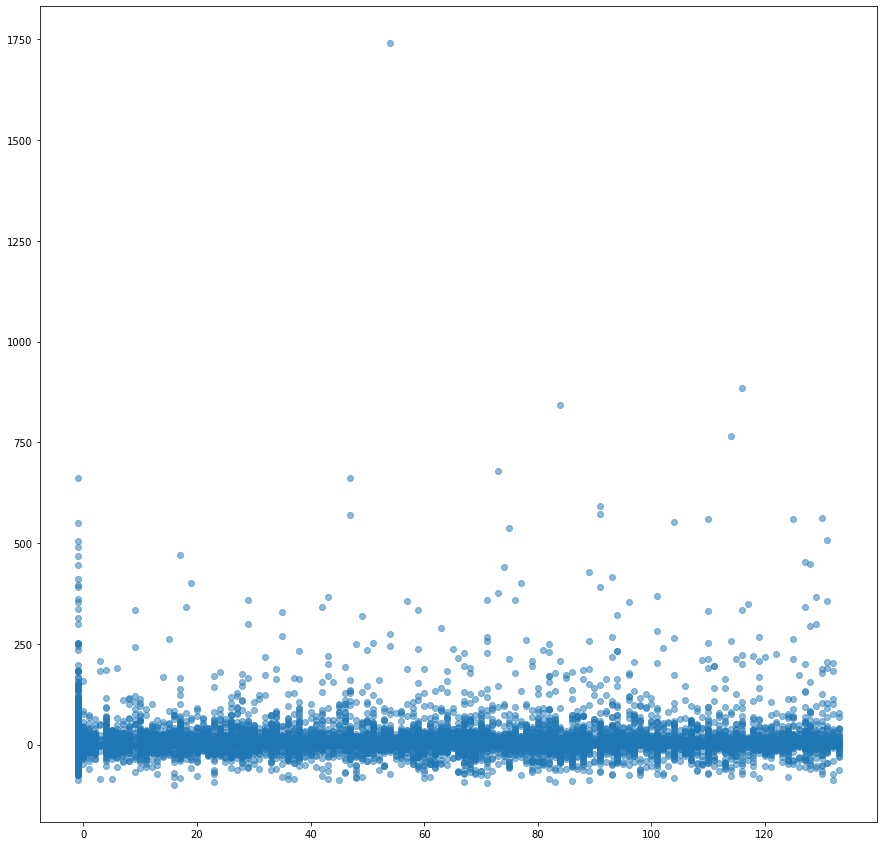

In [147]:
#colors = np.random.rand(N)
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter( Jan2020_sales["cluster"].astype(int), Jan2020_sales["January 2020"].astype(float), alpha=0.5)

In [ ]:

# med_yoy_by_cluster = []

# for cluster in np.unique(Jan2020_sales["cluster"]):
#     med_yoy_by_cluster.append(Jan2020_sales["January 2020"])

# fig, ax = plt.subplots(figsize=(15, 15))
# ax.scatter( Jan2020_sales["cluster"].astype(int), Jan2020_sales["January 2020"].astype(float), alpha=0.5)